#### Background of the data

- transactions (orders and cancelations) from mostly wholesalers on a UK online retail store
- online purchases only
- period of transactions: 01/12/2010 to 09/12/2011
- around 540,000 data points, most of them relate to UK customers
- retail shop mainly sells all-occasion presents

The data set originally comes from the UCI Machine Learning Repository, where it is maintained and accessible by the "Online Retail". I accessed the data set in July 2020 from the following repository on kaggle.com: https://www.kaggle.com/carrie1/ecommerce-data

#### Objective

The aim of this notebook is to investigate on the purchasing habits that customers from different countries followed when they did the purchased contained in this data set.
To do so, the purchases are grouped in seasonal sections and analyzed per country. Based on the product bought, its price, and its quantity findings can be obtained and analyzed. A further variable 'Price_total', which I created myself, is taken into consideration here.
For the analysis, I mainly focus on comparative visualizations. 

In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
import plotly.express as px 
import cufflinks as cf            
import chart_studio.tools as tls
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode    #for plotly offline plotting (to avoid empty plot output issue)
init_notebook_mode(connected=True)

### 1. Data description

##### Loading data, encoding it and getting a quick overview of its structure

In [8]:
raw_data = pd.read_csv('C:/Users/HP/Documents/Python Projects/E-Commerce UK data/E-Commerce UK data.csv',encoding="ISO-8859-1")
raw_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
raw_data.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


##### Variable description

The data set comes with 541,909 entries and 8 variables, which are:

- InvoiceNo: 6-digit invoice number that is unique per transaction. *Note: A letter 'C' in front of an entry indicates that the order was canceled. Logically, the relating original order (with same transaction details) shall exist in the data set, as well.*
- StockCode: 5-digit internal product code that is unique per produce
- Description: Short description/name of a product
- Quantity: a numeric value indicating the quantity that a product was contained in a transaction
- InvoiceDate: shows date (mm/dd/yyyy) and time (hrs:min) that a transaction invoice was initiated
- UnitPrice: Numeric value indicating a product's price per unit in Pound sterling (GBP)
- CustomerID: 5-digit identification number that is unique per customer
- Country: Country name of the customers residence

From the description table above we can see that all variables except for 'Description' and 'CustomerID' have 541,909 entries, meaning that there are no blank entries(NA's). Dealing with the missing values of the two mentioned variables will be undertaken in chapter 2.

### 2. Data cleaning and initial analysis

##### Removing missing values

- Variable 'CustomerID'

In [10]:
raw_data['CustomerID'].isna().sum(), raw_data['CustomerID'].isna().sum()/len(raw_data)

(135080, 0.249266943342886)

This variable misses the customer ID information for 135,080 transactions, which equals a whopping 24,9% of all transactions. The only reasonable solution here is to remove the transactions where the Customer ID is missing.

In [11]:
data_no_mv = raw_data.copy()
data_no_mv.dropna(axis=0, subset = ['CustomerID'], inplace=True)

#####both codes below not really converting the column to strings, but to 'Object'
#data_no_mv['CustomerID'].to_string().replace('.0', '') 

#data_no_mv['CustomerID'] = data_no_mv['CustomerID'].astype(str).replace('.0', '')     #Convert CustomerIDs to strings and remove '.0' ending

data_no_mv.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Luckily the transactions with missing values in the variable 'Description' where all contained in those that also had missing values in 'CustomerID'.
So, dropping the observations containing missing values for CustomerID simultaneously removed those for 'Description', which leads us with no missing values in the whole data set.

##### Removing duplicates

In [16]:
data_no_mv.duplicated().sum()

5225

In [17]:
data_no_dupl = data_no_mv.drop_duplicates()

##### Convert time series data

In [18]:
import datetime as dt
# make copy of data first to avoid ~SettingWithCopyWarning~
data_var1 = data_no_dupl[data_no_dupl['InvoiceDate'].notnull()].copy()
data_var1['InvoiceDate'] = pd.to_datetime(data_var1['InvoiceDate']).dt.strftime('%Y-%m-%d')
data_var1.reset_index(drop=True)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
401599,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680.0,France
401600,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680.0,France
401601,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680.0,France
401602,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680.0,France


#### 2.1 Continuous variables

##### Treating outliers

To check outliers in the numerical variables, distribution plots are drawn below

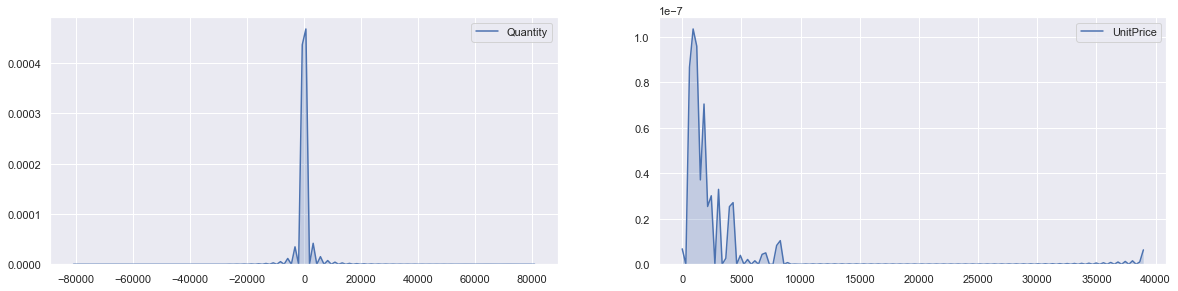

In [19]:
from pylab import *
sns.set(rc={"figure.figsize": (20, 10)})
subplot(2,2,1)
ax = sns.kdeplot(data_var1['Quantity'],shade=True)
subplot(2,2,2)
ax = sns.kdeplot(data_var1['UnitPrice'],shade=True)
plt.show()

##### *a) Quantity*

In [20]:
data_var1['Quantity'].unique()

array([     6,      8,      2,     32,      3,      4,     24,     12,
           48,     18,     20,     36,     80,     64,     10,    120,
           96,     23,      5,      1,     -1,     50,     40,    100,
          192,    432,    144,    288,    -12,    -24,     16,      9,
          128,     25,     30,     28,      7,     72,    200,    600,
          480,     -6,     14,     -2,     -4,     -5,     -7,     -3,
           11,     70,    252,     60,    216,    384,     27,    108,
           52,  -9360,     75,    270,     42,    240,     90,    320,
           17,   1824,    204,     69,    -36,   -192,   -144,    160,
         2880,   1400,     19,     39,    -48,    -50,     56,     13,
         1440,     -8,     15,    720,    -20,    156,    324,     41,
          -10,    -72,    -11,    402,    378,    150,    300,     22,
           34,    408,    972,    208,   1008,     26,   1000,    -25,
         1488,    250,   1394,    400,    110,    -14,     37,    -33,
      

Having a look at the data distribution of the 'Quantity' variable reveals that there are many negative values present. These stem from cancelled orders. Due to large ordered (and canceled) quantities, the distribution is very wide spread in negative and positive direction.
From the descriptive statistics table in the beginning it can be observed that 75% of orders contained a quantity of 10 or less items. 

To get a clearer view on the majority of the data points, I will zoom in a little and neglect the extreme values on both ends.

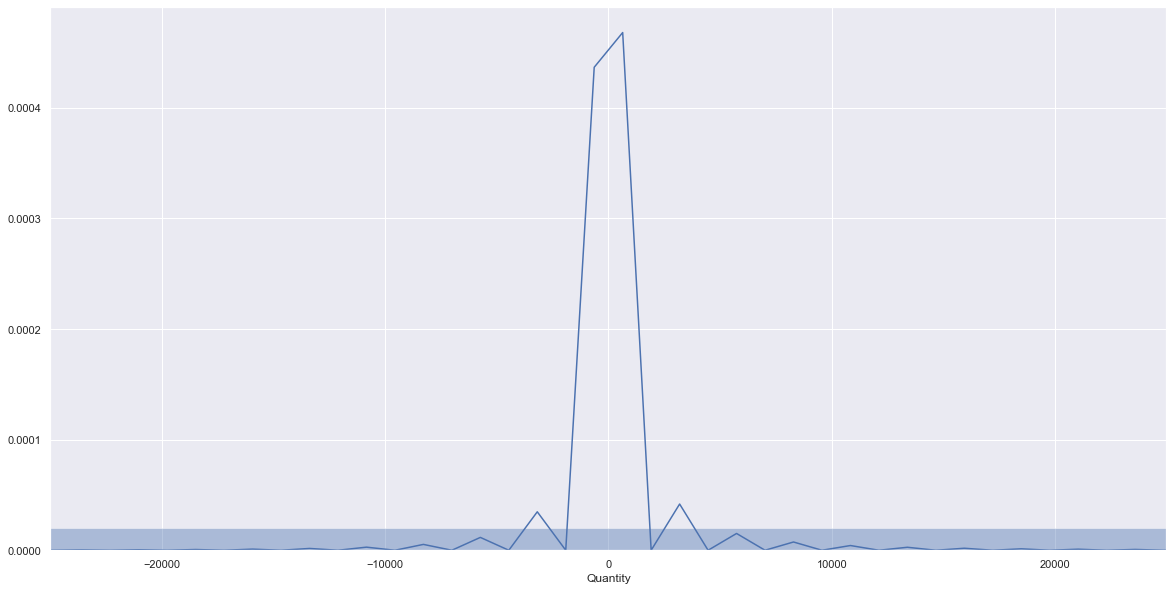

In [21]:
sns.distplot(data_var1['Quantity'], xlim(-25000,25000))

Noteworthy is that there is a large amount of canceled orders. I will obtain more details on these cases later on.

##### *b) UnitPrice*

Nearly all unit prices fall in the range of 0-10,000 GBP. Suspicious is the small peak at a unit price of close to 40,000 GBP. I will investigate this manually to see if the incidents there are authentic transactions or potential errors/outliers.

In [22]:
data_var1['UnitPrice'].loc[lambda x : x >10000]

222681    38970.0
Name: UnitPrice, dtype: float64

In [23]:
data_var1.loc[222681]

InvoiceNo             C556445
StockCode                   M
Description            Manual
Quantity                   -1
InvoiceDate        2011-06-10
UnitPrice               38970
CustomerID              15098
Country        United Kingdom
Name: 222681, dtype: object

In fact, only one transaction exists where the unit price was greater than 10,000 GBP. The transaction relates to a canceled order with the product description 'Manual' and a quantity of -1. Since this transaction is not a regular one, I will remove it from the data set.

Keep observations with UnitPrice < 10000 GBP only

In [24]:
data_2= data_var1[data_var1.UnitPrice < 10000]

A further observation from the distribution plot above is the relatively high number of unit prices '0'. I will have a look at these values to see details and understand them.

In [25]:
data_2.loc[data_2.UnitPrice == 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04,0.0,14410.0,United Kingdom


There are 40 data points with a unit price of 0 GBP. Apart from the few items with description 'Manual' all others indicate a valid product describtion. Also, all other columns contain information. Nonetheless, missing unit prices are meaningless for this analysis, so I decide to discard these 40 data points from the data set.

In [26]:
# Keep only those entries where the unit price is NOT 0.
data_2 =  data_2.loc[data_2.UnitPrice != 0]

##### Identify unique transactions, customers, products and countries

In [27]:
overview = pd.DataFrame ([{'Customers':len(data_2.CustomerID.unique()),
                'Transactions': len(data_2.InvoiceNo.unique()),
                'Products': len(data_2.StockCode.unique()),
                'Countries': len(data_2.Country.unique())}],             
              columns = ['Customers', 'Transactions', 'Products', 'Countries'],
             index = ['#'])
overview

,Customers,Transactions,Products,Countries
#,4371,22185,3684,37


#### 2.2 Categorical variables

##### *a) Transactions and canceled orders*

First, I will have a look at the transactions to find out how many of them were canceled.

In [28]:
data_2['Canceled order'] = data_2['InvoiceNo'].apply(lambda x:int('C' in x))
print(data_2['Canceled order'].sum(), 'orders were canceled.')     

8871 orders were canceled.


As the table below shows, when sorting the data by customer we can see that some customers (e.g. customer ID 12346) have canceled all their ordered quantity, and some have only canceled a part of it (e.g. customer ID 12403). What also catches one's attention is that the invoice number of the canceled order (C541433) does not relate to the one of the original order (541431), but differs slightly at the last digit.

In [29]:
grouped_invoices = data_2.groupby(by =['CustomerID','InvoiceNo']).sum()
grouped_invoices.head(150)

Quantity  UnitPrice  Canceled order
CustomerID InvoiceNo                                     
12346.0    541431        74215       1.04               0
           C541433      -74215       1.04               1
12347.0    537626          319      89.59               0
           542237          315      73.17               0
           549222          483      62.29               0
...                        ...        ...             ...
12399.0    563172          175      27.22               0
12401.0    543537           11      48.40               0
12402.0    541675           94      36.20               0
12403.0    572184           96      35.40               0
           C572187          -1      18.00               1

[150 rows x 3 columns]

Let's have a look at customer 12403, who canceled only 1 out of his 96 ordered items.

In [30]:
data_2[data_2['CustomerID'].astype(str).str.contains('12403')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Canceled order
410895,572184,84997D,CHILDRENS CUTLERY POLKADOT PINK,40,2011-10-21,4.15,12403.0,Denmark,0
410896,572184,84997C,CHILDRENS CUTLERY POLKADOT BLUE,20,2011-10-21,4.15,12403.0,Denmark,0
410897,572184,84997A,CHILDRENS CUTLERY POLKADOT GREEN,32,2011-10-21,4.15,12403.0,Denmark,0
410898,572184,21770,OPEN CLOSED METAL SIGN,2,2011-10-21,4.95,12403.0,Denmark,0
410899,572184,POST,POSTAGE,2,2011-10-21,18.00,12403.0,Denmark,0
411009,C572187,POST,POSTAGE,-1,2011-10-21,18.00,12403.0,Denmark,1


Here we find another specialty in the data set, namely the string 'POSTAGE' in the Description column. The customer ordered postage twice (probably by accident), and then canceled one of the postages nine minutes later.

Since a canceled order cannot easily and automatically be allocated to its original order, including the canceled orders in the data does not add any value to my analysis.
The same is true for having items with StockCode 'POST' and 'POSTAGE' listed as products. Therefore, I decide to
1. remove all canceled orders from the data set
2. remove all 'POSTAGE' products from the data set

In [31]:
#1. Keep all rows where 'Canceled order' is 0 (False) and drop column 'Canceled order'
data_no_c = data_2[data_2['Canceled order'] == 0]
data_no_c = data_no_c.drop(data_no_c.columns[-1],axis=1)

#2. Drop rows with the description 'Postage' (at the same time I also drop entries that are not real products, but just described as 'Discount')
data_3 = data_no_c[data_no_c['Description'] != 'POSTAGE']
data_3 = data_3[data_3['Description'] != 'Discount']

##### - Order volume

For further analysis it is of interest to retrieve the total price of an invoice. I multiply the unit price and the quantity per transaction and sum them up.

In [32]:
data_3['Price_total'] = data_3.Quantity * data_3.UnitPrice

##### *b) InvoiceDate*

In [33]:
data_3.InvoiceDate.min(), data_3.InvoiceDate.max()

('2010-12-01', '2011-12-09')

The purchases (i.e. their invoices) date from December 2010 until December 2011

##### Graphical representation of issued invoices per day over one year

In [34]:
# To plot the invoices per day the date format needs to be converted from hours and minute format to day format
data_3['InvoiceDate'] = pd.to_datetime(data_var1['InvoiceDate']).dt.strftime('%Y-%m-%d')

In [35]:
# Grouping the data by invoice date so that I can plot the number of issued invoices over time
data3_grouped = data_3.groupby('InvoiceDate').count().reset_index()

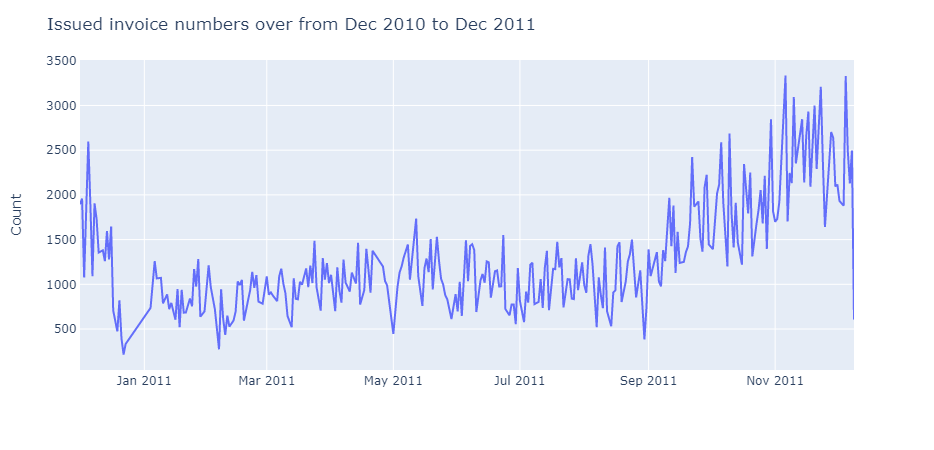

In [36]:
fig = px.line(data3_grouped, x='InvoiceDate', y='InvoiceNo')
fig.update_layout(title_text= 'Issued invoice numbers over from Dec 2010 to Dec 2011')
fig.update_yaxes(title_text="Count")
fig.update_xaxes(title_text=" ")
fig.show()

The graphic above reveals some interesting observations, such as:
- invoice volume was fairly constant from January 2011 until September 2011
- December 2010 and the last quarter of 2011 saw a significant increase in issued invoices. Since the products in this data set are gift articles, the increase very likely stems from the approaching Christmas holidays
- no invoices between 23.December 2010 and 4.January 2011. A plausible explanation could be that the selling company did not handle any orders during that time due to Christmas holidays. Furthermore, many customers of the store are wholesales. So, they surely place their orders for Christmas gift articles far earlier than Christmas and therefore do not need to order again directly after Christmas.


##### *c) Products*

There are 3,664 unique stock codes, i.e. as many unique products in the data set. However, that these products are not always 'real' products could be observed from a) Transactions and canceled order, where entries like 'postage' were found. In that example we found that the StockCode contains only of the letters 'POST', but does not follow the structure of numbers+letter or numbers only, as 'normal' stock codes do. To make sure to exclude all such irrelevant entries I search the StockCode variable for entries where no numbers, but only letters exist. 

In [37]:
len(data_3.StockCode.unique())

3664

In [38]:
# Show the unqiue stock codes of not 'normal' products and their description (so that we can see which 'product' a code relates to)
none_products_codes = data_3[data_3['StockCode'].str.contains('^[a-zA-Z]+')]['StockCode'].unique()
none_products_descr = data_3[data_3['StockCode'].str.contains('^[a-zA-Z]+')]['Description'].unique()
print(none_products_codes)
print(none_products_descr)

['C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']
['CARRIAGE' 'Manual' 'Bank Charges' 'PADS TO MATCH ALL CUSHIONS'
 'DOTCOM POSTAGE']


All these items relate to some sort of service fee or charges. As they do not add any value to the analysis, I will exclude them from the data set hereafter.

In [39]:
# Remove the 'non-products' from the data set (which equals 450 data points)
data_3.drop(data_3[data_3['StockCode'].str.contains('^[a-zA-Z]+')].index, axis = 0, inplace=True)

##### *d) Countries*

Show countries on a world map

In [40]:
data_3.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [41]:
# Grouping the data by country and the amount of ... each country made 
orders_country = data_3[['Country', 'InvoiceNo']].groupby('Country').count().reset_index()

In [42]:
country = list(data_3['Country'])
order_volume =  list(data_3['Price_total'])

from pyecharts.charts import Map,Geo
from pyecharts import options as opts
from pyecharts.globals import ThemeType

list1 = [[country[i],order_volume[i]] for i in range(len(country))]

map_1 = Map(init_opts=opts.InitOpts(width='1000px', height='460px'))
map_1.add('Order volume in GBP', list1, maptype='world', is_map_symbol_show=False) #add world map
map_1 = Map(init_opts=opts.InitOpts(width='1000px', height='460px',theme=ThemeType.ROMANTIC)) 

map_1.set_series_opts(label_opts=opts.LabelOpts(is_show=False)) 
map_1.set_global_opts(
visualmap_opts=opts.VisualMapOpts(max_=1100000,is_piecewise=True,pieces=[
 {'min': 500000},
 {'min': 200000, 'max': 499999},
 {'min': 100000, 'max': 199999},
 {'min': 50000, 'max': 99999},
 {'min': 10000, 'max': 49999},
 {'max': 9999},]),
 title_opts=opts.TitleOpts(
 title='Order volume per country (in GBP)',
 subtitle='xxx',
 pos_left='center',
 padding=0,
 item_gap=2,
 title_textstyle_opts= opts.TextStyleOpts(color='darkblue',
 font_weight='bold',
 font_family='Courier New',
 font_size=30), 
 subtitle_textstyle_opts= opts.TextStyleOpts(color='grey',
 font_weight='bold',
 font_family='Courier New',
 font_size=13)), 
 legend_opts=opts.LegendOpts(is_show=False))
map_1.render_notebook()

### 3. Data analysis 

distribution by order volume (in GPB)

- bar chart (for order volume) + line on top (quantity) in once graph

The different total prices of orders cannot be represented graphically individually (because there are simply too many), so I decide to group them.

In [43]:
price_range = [0,25,50, 100, 250, 1000, 5000, 200000]
order_volume_df = pd.DataFrame(data_3['Price_total'])
order_volume_df.rename(columns = {'Price_total':'Count'}, inplace = True)
order_volume_df = order_volume_df.groupby(pd.cut(data_3.Price_total, price_range, labels = ['0-25', '25-50', '50-100', '100-250', '250-1,000', '1,000-5,000','5,000-200,000'])).count()
order_volume_df.reset_index(level=0, inplace=True)
order_volume_df

,Price_total,Count
0,0-25,327883
1,25-50,36954
2,50-100,14918
3,100-250,8761
4,"250-1,000",2340
5,"1,000-5,000",288
6,"5,000-200,000",6


fig = px.bar( order_volume_df, x ='Price_total', y = 'Count')
fig.show()

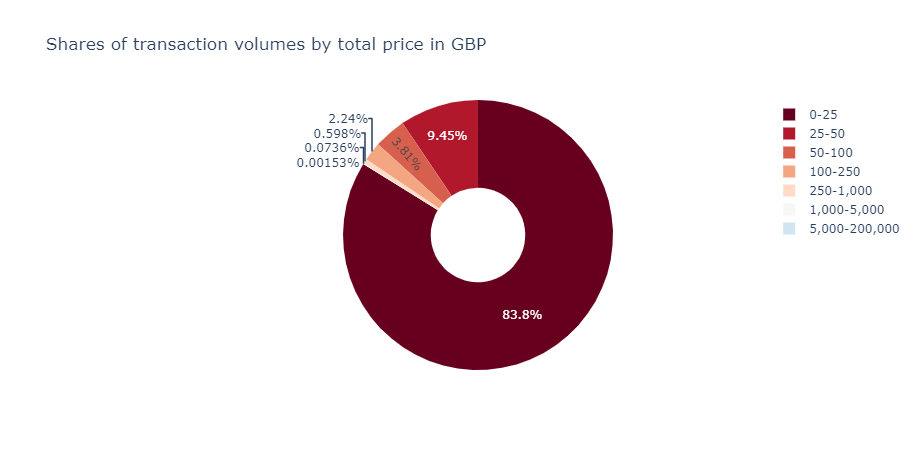

In [44]:
fig = px.pie(order_volume_df, values='Count', names='Price_total', title='Shares of transaction volumes by total price in GBP',color_discrete_sequence=px.colors.sequential.RdBu, hole=.35)
fig.show()

As the pie chart above illustrates more than 80% of all total transaction sums are less than 25GBP. With increasing total transaction prices do their share decline drastically. The highest two categories are hardly visible on the chart, as their counts are relatively small (288 and 6, respectively).

#### Analysis on main customers

##### Order volume per customer

Next, I am going to group order volumes per customer ID to detect those customers that spent the most money.

In [45]:
customer_price_grouped = data_3.groupby('CustomerID').sum().sort_values(by=['Price_total'],ascending=False)
customer_price_grouped

,Quantity,UnitPrice,Price_total
CustomerID,,,
14646.0,196844,4933.09,279138.02
18102.0,64124,1940.92,259657.30
17450.0,69973,1135.32,194390.79
16446.0,80997,4.98,168472.50
14911.0,80154,18601.01,136161.83
...,...,...,...
16878.0,12,4.75,13.30
17956.0,1,12.75,12.75
14792.0,2,6.20,6.20


Graphical representation of the total sum that customers spent in the entire one-year period.

In [46]:
#add new index so that previous index 'CustomerId' can be accessed for graph
customer_price_grouped.reset_index(level=0, inplace=True)  

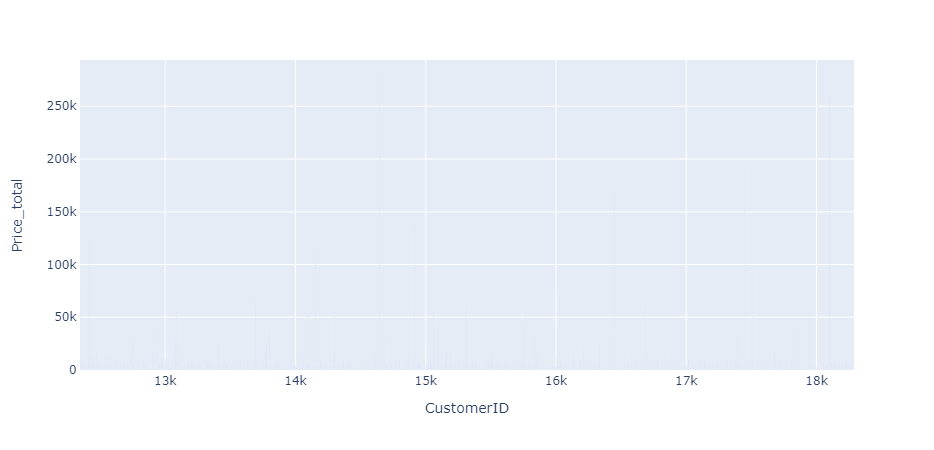

In [47]:
bar_1 = px.bar(customer_price_grouped, x = 'CustomerID', y='Price_total')
bar_1.show()

##### Order timing per customer

### Findings:

- large share (xx %) of customers order large quantities(over xx items) per order
- high share of canceled orders (xx %)